In [1]:
setwd(here::here())

In [2]:
library("metacell")
library("Matrix")
library("ggplot2")
library("ggrepel")
library("tgstat")
library("zoo")
library("qvalue")
library("devtools")
library("data.table")
library("tidyverse")


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: usethis

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.2      v dplyr   1.0.10
v tidyr   1.2.0      v stringr 1.4.0 
v readr   2.1.0      v forcats 1.0.0 
v purrr   0.3.4      

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x tidyr::expand()    masks Matrix::expand()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x tidyr::pack()      masks Matrix::pack()
x purrr::transpose() masks data.table::transpose()
x tidyr::unpack()    masks Matrix::unpack()



In [3]:
scdb_init("scrna_db/",force_reinit = T)

initializing scdb to scrna_db/



In [4]:
mat_wt = scdb_mat("embexe")
mc_wt = scdb_mc("embexe_recolored")

In [5]:
embryonic_cell_types = mc_wt@color_key$group[c(9, 12, 15, 14, 20, 25, 19, 16, 17, 18, 21, 22, 28, 29, 30, 31, 32, 33, 4, 6, 13, 11, 8, 2, 5, 1, 35, 7, 3, 26, 27, 23, 24, 34, 39, 40, 36, 37, 38, 10, 44, 43, 47, 48, 46, 50, 49, 45)]
wt_cells = names(mc_wt@mc)[!is.na(mat_wt@cell_metadata[names(mc_wt@mc),"transcriptional_rank"])]

The best-match WT transcriptional ranks for the batch of ex utero late streak embryos (*rank 160*) and for the batch of ex utero late head fold embryos (*rank 233*) were computed at the end of the notebook `atlas_projection_exutero`.

In [6]:
### 
ls_matched_ranks = c((160 - 15):(160 + 15))
lhf_matched_ranks = c((233 - 8):(233 + 8))

In [7]:
df_annotation_exutero = read.table('data/exutero_cell_type_annotation.tsv',sep = '\t')
df_annotation_wt =  read.table('data/atlas_self_projection_cell_type.tsv',sep = '\t')

In [8]:
emb_cols <- mc_wt@color_key$color[1:38]
exe_cols <- mc_wt@color_key$color[43:50]

wt_ag <- table(mat_wt@cell_metadata[wt_cells,"transcriptional_rank"],
              factor(x = df_annotation_wt[wt_cells,"projected_color"],levels = mc_wt@color_key$color))

wt_df <- data.frame(Late_streak = colSums(wt_ag[ls_matched_ranks,]), Head_fold = colSums(wt_ag[lhf_matched_ranks,]))

wt_df_emb <- wt_df[emb_cols,]
wt_df_exe <- wt_df[exe_cols,]

exutero_ag <- table(df_annotation_exutero$experiment,
                  factor(x = df_annotation_exutero$projected_color, levels = mc_wt@color_key$color))

exutero_df <- data.frame(Late_streak = exutero_ag["Late_streak",], Head_fold = exutero_ag["Head_fold",])

exutero_df_emb <- exutero_df[emb_cols,]
exutero_df_exe <- exutero_df[exe_cols,]

pool_wide_emb <- data.frame(wt_ls = as.vector(wt_df_emb$Late_streak), 
                            exutero_ls = as.vector(exutero_df_emb$Late_streak),
                            wt_lhf = as.vector(wt_df_emb$Head_fold), 
                            exutero_lhf = as.vector(exutero_df_emb$Head_fold))

pool_wide_emb_n <- data.frame(sapply(1:ncol(pool_wide_emb), function(i){pool_wide_emb[,i]/sum(pool_wide_emb[,i])}))
colnames(pool_wide_emb_n) <- colnames(pool_wide_emb)
pool_wide_emb_n$col <- mc_wt@color_key$color[1:38]

pool_wide_exe <- data.frame(wt_ls = as.vector(wt_df_exe$Late_streak), 
                            exutero_ls = as.vector(exutero_df_exe$Late_streak),
                            wt_lhf = as.vector(wt_df_exe$Head_fold), 
                            exutero_lhf = as.vector(exutero_df_exe$Head_fold))

pool_wide_exe_n <- data.frame(sapply(1:ncol(pool_wide_exe), function(i){pool_wide_exe[,i]/sum(pool_wide_exe[,i])}))
colnames(pool_wide_exe_n) <- colnames(pool_wide_exe)
pool_wide_exe_n$col <- mc_wt@color_key$color[43:50]

In [9]:
pool_col_wide_emb_long <- data.frame(tidyr::pivot_longer(data = pool_wide_emb_n, cols = c(1:4)))
pool_col_wide_emb_long$name <- factor(pool_col_wide_emb_long$name, levels = c("wt_ls","exutero_ls","wt_lhf","exutero_lhf"))
pool_col_wide_exe_long <- data.frame(tidyr::pivot_longer(data = pool_wide_exe_n, cols = c(1:4)))
pool_col_wide_exe_long$name <- factor(pool_col_wide_exe_long$name, levels = c("wt_ls","exutero_ls","wt_lhf","exutero_lhf"))

pool_col_wide_emb_long$col <- factor(pool_col_wide_emb_long$col, levels = rev(mc_wt@color_key$color[c(1:38)]))
pool_col_wide_exe_long$col <- factor(pool_col_wide_exe_long$col, levels = rev(mc_wt@color_key$color[c(43:50)]))

In [10]:
reg <- 1e-2

df.plot.emb <- data.frame(wt_ls = log2(pool_wide_emb_n$wt_ls + reg),
                          exutero_ls = log2(pool_wide_emb_n$exutero_ls + reg),
                          wt_lhf = log2(pool_wide_emb_n$wt_lhf + reg),
                          exutero_lhf = log2(pool_wide_emb_n$exutero_lhf + reg),
                          cell_type_color = pool_wide_emb_n$col)

df.plot.exe <- data.frame(wt_ls = log2(pool_wide_exe_n$wt_ls + reg),
                          exutero_ls = log2(pool_wide_exe_n$exutero_ls + reg),
                          wt_lhf = log2(pool_wide_exe_n$wt_lhf + reg),
                          exutero_lhf = log2(pool_wide_exe_n$exutero_lhf + reg),
                          cell_type_color = pool_wide_exe_n$col)

### Extended Data Figure 6c

In [11]:
source("scripts/atlas_proj.r")

In [12]:
mat_exutero = scdb_mat("exutero_f")
mc_exutero = scdb_mc("exutero_f")
mat_wt = scdb_mat("embexe")
mc_wt = scdb_mc("embexe_recolored")
gset_wt = scdb_gset("embexe")
mc_wt_emb = scdb_mc("emb")

col_to_ct = mc_wt@color_key$group
names(col_to_ct) = mc_wt@color_key$color
ct_to_col = mc_wt@color_key$color
names(ct_to_col) = mc_wt@color_key$group

feat_genes = intersect(names(gset_wt@gene_set),rownames(mat_exutero@mat))

In [13]:
egc_exutero = t(tgs_matrix_tapply(mat_exutero@mat[,names(mc_exutero@mc)],mc_exutero@mc,sum))
egc_exutero = t(t(egc_exutero)/colSums(egc_exutero))
egc_wt = t(tgs_matrix_tapply(mat_wt@mat[,names(mc_wt@mc)],mc_wt@mc,sum))
egc_wt = t(t(egc_wt)/colSums(egc_wt))

In [14]:
exutero_to_wt_projection = project_query_umi_matrix_on_metacell_egc_matrix(mat_query = mat_exutero@mat[feat_genes,],
                                                              mc_egc = egc_wt[feat_genes,])
exutero_to_wt_projection = project_query_mc_egc_on_reference_mc_egc(egc_query = egc_exutero[feat_genes,],
                                                              egc_reference = egc_wt[feat_genes,])
exutero_projected_cell_type = col_to_ct[mc_wt@colors[exutero_to_wt_projection$best_reference_metacell]]

### Extended Data Figure 6 d,e

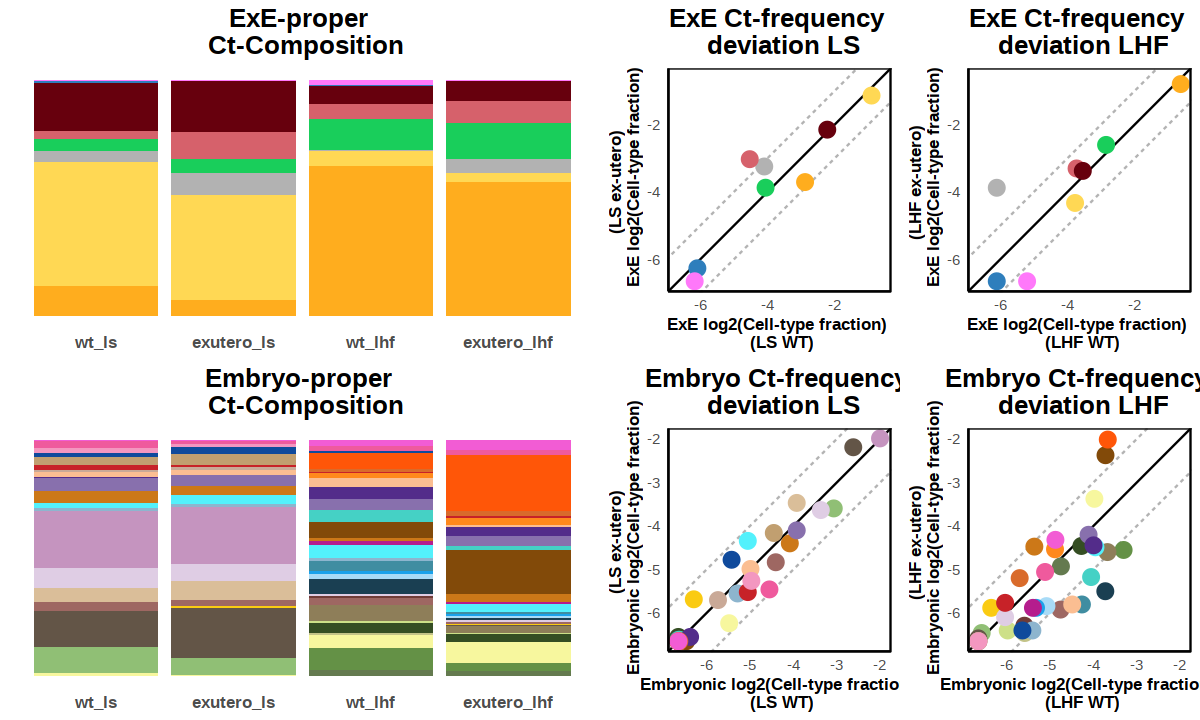

In [15]:
p1 <- ggplot(pool_col_wide_emb_long, aes(name, value, fill = col)) +
  geom_col() +
  ggtitle("Embryo-proper \n Ct-Composition") +
  scale_fill_identity() +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.ticks = element_blank(),
        axis.line = element_blank(),
        axis.text.y = element_blank(),
        axis.text.x = element_text(face = "bold",size = 10),
        axis.title = element_blank(),
        panel.grid = element_blank(),panel.border = element_blank(), legend.position="None")

p2 <- ggplot(pool_col_wide_exe_long, aes(name, value, fill = col)) +
  geom_col() +
  ggtitle("ExE-proper \n Ct-Composition") +
  scale_fill_identity() +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.ticks = element_blank(),
        axis.line = element_blank(),
        axis.text.y = element_blank(),
        axis.text.x = element_text(face = "bold",size = 10),
        axis.title = element_blank(),
        panel.grid = element_blank(),panel.border = element_blank(), legend.position="None")

min_lim_emb <- min(df.plot.emb[,1:4])
max_lim_emb <- max(df.plot.emb[,1:4])
# max_lim_emb <- -0.5

min_lim_exe <- min(df.plot.exe[,1:4])
max_lim_exe <- max(df.plot.exe[,1:4])
# max_lim_exe <- -0.5

p3 <- ggplot(data = df.plot.emb,aes(wt_ls, exutero_ls, col=cell_type_color)) +
    geom_abline(slope = 1,intercept = 0) +
  geom_abline(slope = 1,intercept = 1, col = "gray70",linetype = 'dashed') +
  geom_abline(slope = 1,intercept = -1, col = "gray70",linetype = 'dashed') +
  geom_point(size = 4) +
ylim(min_lim_emb,max_lim_emb) + 
xlim(min_lim_emb,max_lim_emb) +
  ggtitle(label = "Embryo Ct-frequency \n deviation LS") +
  scale_color_identity() +
ylab("(LS ex-utero) \n Embryonic log2(Cell-type fraction)") +
xlab("Embryonic log2(Cell-type fraction) \n (LS WT)") +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.ticks = element_blank(),
        axis.title = element_text(face = "bold",size = 10),
        panel.grid = element_blank(),panel.border = element_rect(fill=NA),legend.position="None")

p4 <- ggplot(data = df.plot.exe,aes(wt_ls, exutero_ls, col=cell_type_color)) +
    geom_abline(slope = 1,intercept = 0) +
  geom_abline(slope = 1,intercept = 1, col = "gray70",linetype = 'dashed') +
  geom_abline(slope = 1,intercept = -1, col = "gray70",linetype = 'dashed') +
  geom_point(size = 4) +
ylim(min_lim_exe,max_lim_exe) + 
xlim(min_lim_exe,max_lim_exe) +
  ggtitle(label = "ExE Ct-frequency \n deviation LS") +
  scale_color_identity() +
ylab("(LS ex-utero) \n ExE log2(Cell-type fraction)") +
xlab("ExE log2(Cell-type fraction) \n (LS WT)") +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.ticks = element_blank(),
        axis.title = element_text(face = "bold",size = 10),
        panel.grid = element_blank(),panel.border = element_rect(fill=NA),legend.position="None")


p5 <- ggplot(data = df.plot.emb,aes(wt_lhf, exutero_lhf, col=cell_type_color)) +
    geom_abline(slope = 1,intercept = 0) +
  geom_abline(slope = 1,intercept = 1, col = "gray70",linetype = 'dashed') +
  geom_abline(slope = 1,intercept = -1, col = "gray70",linetype = 'dashed') +
  geom_point(size = 4) +
  ggtitle(label = "Embryo Ct-frequency \n deviation LHF") +
  scale_color_identity() +
ylim(min_lim_emb,max_lim_emb) + 
xlim(min_lim_emb,max_lim_emb) +
ylab("(LHF ex-utero) \n Embryonic log2(Cell-type fraction)") +
xlab("Embryonic log2(Cell-type fraction) \n (LHF WT)") +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.ticks = element_blank(),
        axis.title = element_text(face = "bold",size = 10),
        panel.grid = element_blank(),panel.border = element_rect(fill=NA),legend.position="None")

p6 <- ggplot(data = df.plot.exe,aes(wt_lhf, exutero_lhf, col=cell_type_color)) +
  geom_abline(slope = 1,intercept = 0) +
  geom_abline(slope = 1,intercept = 1, col = "gray70",linetype = 'dashed') +
  geom_abline(slope = 1,intercept = -1, col = "gray70",linetype = 'dashed') +
  geom_point(size = 4) +
  ggtitle(label = "ExE Ct-frequency \n deviation LHF") +
  scale_color_identity() +
ylim(min_lim_exe,max_lim_exe) + 
xlim(min_lim_exe,max_lim_exe) +
ylab("(LHF ex-utero) \n ExE log2(Cell-type fraction)") +
xlab("ExE log2(Cell-type fraction) \n (LHF WT)") +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.ticks = element_blank(),
        axis.title = element_text(face = "bold",size = 10),
        panel.grid = element_blank(),panel.border = element_rect(fill=NA),legend.position="None")

options(repr.plot.width=10, repr.plot.height=6)
gridExtra::grid.arrange(gridExtra::arrangeGrob(p2,p1), gridExtra::arrangeGrob(p4,p6,p3, p5), ncol = 2)